In this notebook we'll be exploring how to use CAD-based geometries in OpenMC via the [DagMC](https://svalinn.github.io/DAGMC/index.html) toolkit. The models we'll be using in this notebook have already been created using [Trelis](https://www.csimsoft.com/trelis) and faceted into a surface mesh represented as `.h5m` files in the [Mesh Oriented DatABase](https://press3.mcs.anl.gov/sigma/moab-library/) format. We'll be retrieving these files using the function below.



In [1]:
import urllib.request

fuel_pin_url = 'https://tinyurl.com/y3ugwz6w' # 1.2 MB
teapot_url = 'https://tinyurl.com/y4mcmc3u' # 29 MB

def download(url):
    """
    Helper function for retrieving dagmc models
    """
    u = urllib.request.urlopen(url)
    
    if u.status != 200:
        raise RuntimeError("Failed to download file.")
    
    # save file as dagmc.h5m
    with open("dagmc.h5m", 'wb') as f:
        f.write(u.read())

This notebook is intended to demonstrate how DagMC problems are run in OpenMC. For more information on how DagMC models are created, please refer to the [DagMC User's Guide](https://svalinn.github.io/DAGMC/usersguide/index.html).


# CAD-Based Geometry in OpenMC using [DagMC](https://svalinn.github.io/DAGMC/)

In [2]:
%matplotlib inline
from IPython.display import Image
import openmc

To start, we'll be using a simple U235 fuel pin surrounded by a water moderator, so let's create those materials.

In [3]:
 # materials
u235 = openmc.Material(name="fuel")
u235.add_nuclide('U235', 1.0, 'ao')
u235.set_density('g/cc', 11)
u235.id = 40

water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0, 'ao')
water.add_nuclide('O16', 1.0, 'ao')
water.set_density('g/cc', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')
water.id = 41

mats = openmc.Materials([u235, water])
mats.export_to_xml()

Now let's get our DAGMC geometry. We'll be using prefabricated models in this notebook. For information on how to create your own DAGMC models, you can refer to the instructions [here](https://svalinn.github.io/DAGMC/usersguide/trelis_workflow.html).

Let's download the DAGMC model. These models come in the form of triangle surface meshes stored using the the Mesh Oriented datABase ([MOAB](https://press3.mcs.anl.gov/sigma/moab-library/)) in an HDF5 file with the extension `.h5m`. An example of a coarse triangle mesh looks like:

![DagMC Cylinder](./images/cylinder_mesh.png)

First we'll need to grab some pre-made DagMC models.

In [4]:
download(fuel_pin_url)

OpenMC expects that the model has the name "dagmc.h5m" so we'll name the file that and indicate to OpenMC that a DAGMC geometry is being used by setting the `settings.dagmc` attribute to `True`.

In [5]:
settings = openmc.Settings()
settings.dagmc = True
settings.batches = 10
settings.inactive = 2
settings.particles = 5000
settings.export_to_xml()

Unlike conventional geometries in OpenMC, we really have no way of knowing what our model looks like at this point. Thankfully DagMC geometries can be plotted just like any other OpenMC geometry to give us an idea of what we're now working with.

Note that material assignments have already been applied to this model. Materials can be assigned either using ids or names of materials in the `materials.xml` file. It is recommended that material names are used for assignment for readability.

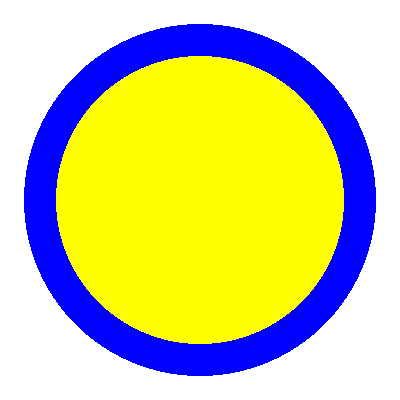

In [6]:
p = openmc.Plot()
p.width = (25.0, 25.0)
p.pixels = (400, 400)
p.color_by = 'material'
p.colors = {u235: 'yellow', water: 'blue'}
openmc.plot_inline(p)

Now that we've had a chance to examine the model a bit, we can finish applying our settings and add a source.

In [7]:
settings.source = openmc.Source(space=openmc.stats.Box([-4., -4., -4.],
                                                       [ 4.,  4.,  4.]))
settings.export_to_xml()

Tallies work in the same way when using DAGMC geometries too. We'll add a tally on the fuel cell here.

In [8]:
tally = openmc.Tally()
tally.scores = ['total']
tally.filters = [openmc.CellFilter(1)]
tallies = openmc.Tallies([tally])
tallies.export_to_xml()

Now we're ready to run the simulation just like any other OpenMC run.

In [9]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## More Complicated Geometry

Neat! But this pincell is something we could've done with CSG. Let's take a look at something more complex. We'll download a pre-built model of the [Utah teapot](https://en.wikipedia.org/wiki/Utah_teapot) and use it here.

In [10]:
download(teapot_url)

![Utah Teapot](./images/teapot.jpg)

Our teapot is made out of iron, so we'll want to create that material and make sure it is in our `materials.xml` file.

In [11]:
iron = openmc.Material(name="iron")
iron.add_nuclide("Fe54", 0.0564555822608)
iron.add_nuclide("Fe56", 0.919015287728)
iron.add_nuclide("Fe57", 0.0216036861685)
iron.add_nuclide("Fe58", 0.00292544384231)
iron.set_density("g/cm3", 7.874)
mats = openmc.Materials([iron, water])
mats.export_to_xml()

To make sure we've updated the file correctly, let's make a plot of the teapot.

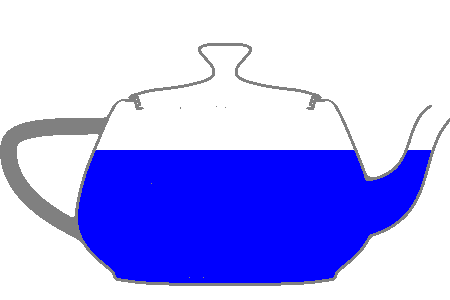

In [12]:
p = openmc.Plot()
p.basis = 'xz'
p.origin = (0.0, 0.0, 0.0)
p.width = (30.0, 20.0)
p.pixels = (450, 300)
p.color_by = 'material'
p.colors = {iron: 'gray', water: 'blue'}
openmc.plot_inline(p)

Here we start to see some of the advantages CAD geometries provide. This particular file was pulled from the [GrabCAD](https://grabcad.com/library) and pushed through the DAGMC workflow without modification (other than the addition of material assignments). It would take a considerable amount of time to create a model like this using CSG!

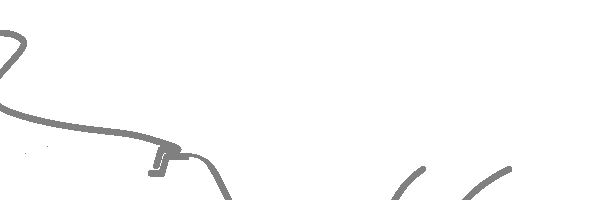

In [13]:
p.width = (18.0, 6.0)
p.basis = 'xz'
p.origin = (10.0, 0.0, 5.0)
p.pixels = (600, 200)
p.color_by = 'material'
openmc.plot_inline(p)

Now let's brew some tea! ... using a very hot neutron source. We'll use some well-placed point sources distributed throughout the model.

In [14]:
settings = openmc.Settings()
settings.dagmc = True
settings.batches = 10
settings.particles = 5000
settings.run_mode = "fixed source"

src_locations = ((-4.0, 0.0, -2.0),
                 ( 4.0, 0.0, -2.0),
                 ( 4.0, 0.0, -6.0),
                 (-4.0, 0.0, -6.0),
                 (10.0, 0.0, -4.0),
                 (-8.0, 0.0, -4.0))

# we'll use the same energy for each source
src_e = openmc.stats.Discrete(x=[12.0,], p=[1.0,])

# create source for each location
sources = []
for loc in src_locations:
    src_pnt = openmc.stats.Point(xyz=loc)
    src = openmc.Source(space=src_pnt, energy=src_e)
    sources.append(src)

src_str = 1.0 / len(sources)
for source in sources:
    source.strength = src_str

settings.source = sources
settings.export_to_xml()

...and setup a couple mesh tallies. One for the kettle, and one for the water inside.

In [15]:
mesh = openmc.RegularMesh()
mesh.dimension = (120, 1, 40)
mesh.lower_left = (-20.0, 0.0, -10.0)
mesh.upper_right = (20.0, 1.0, 4.0)

mesh_filter = openmc.MeshFilter(mesh)

pot_filter = openmc.CellFilter([1])
pot_tally = openmc.Tally()
pot_tally.filters = [mesh_filter, pot_filter]
pot_tally.scores = ['flux']

water_filter = openmc.CellFilter([5])
water_tally = openmc.Tally()
water_tally.filters = [mesh_filter, water_filter]
water_tally.scores = ['flux']


tallies = openmc.Tallies([pot_tally, water_tally])
tallies.export_to_xml()

In [16]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Note that the performance is significantly lower than our pincell model due to the increased complexity of the model, but it allows us to examine tally results like these:

In [17]:
sp = openmc.StatePoint("statepoint.10.h5")

water_tally = sp.get_tally(scores=['flux'], id=water_tally.id)
water_flux = water_tally.mean
water_flux.shape = (40, 120)
water_flux = water_flux[::-1, :]

pot_tally = sp.get_tally(scores=['flux'], id=pot_tally.id)
pot_flux = pot_tally.mean
pot_flux.shape = (40, 120)
pot_flux = pot_flux[::-1, :]

del sp

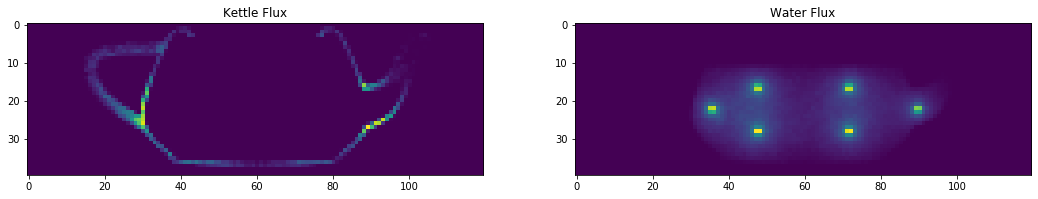

In [18]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(18, 16))

sub_plot1 = plt.subplot(121, title="Kettle Flux")
sub_plot1.imshow(pot_flux)

sub_plot2 = plt.subplot(122, title="Water Flux")
sub_plot2.imshow(water_flux)